In [3]:
%pip install ultralytics
%pip install torchvision==0.21


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 3.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 MB 2.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 2.6.0.dev20241007
    Uninstalling torch-2.6.0.dev20241007:
      Successfully uninstalled torch-2.6.0.dev20241007
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.20.0.dev20241007
    Uninstalling torchvision-0.20.0.dev20241007:
      Successfully uninstalled torchvision-0.20.0.dev20241007
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.5.0.dev20241007 requires torch==2.6.0.dev20241007, but you have tor

In [6]:
import json

with open('./data/InsPLAD-det/annotations/instances_val.json') as f:
    data = json.load(f)

# Show 5 example filenames
for img in data["val"][:5]:
    print(img["file_name"])

val/284-1_DJI_0495.jpg
val/284-1_DJI_0496.jpg
val/284-1_DJI_0497.jpg
val/284-1_DJI_0498.jpg
val/284-1_DJI_0500.jpg


In [7]:
import os

print(os.path.exists('data/InsPLAD-det/train/images/327-2_DJI_0002.jpg'))

True


In [8]:
import json

path = './data/InsPLAD-det/annotations/instances_val.json'
#
# with open(path) as f:
#     coco = json.load(f)
#
# # Add val/ prefix if not present
# for img in coco['val']:
#     if not img['file_name'].startswith('val/'):
#         img['file_name'] = f"val/{img['file_name']}"
#
# with open(path, 'w') as f:
#     json.dump(coco, f)

In [9]:
from ultralytics.data.converter import convert_coco

# Convert COCO annotation to YOLO format
convert_coco(labels_dir=path, use_segments=False, use_keypoints=False)

COCO data converted successfully.
Results saved to /Users/azizbek/Documents/Projects/PowerLine/coco_converted


In [ ]:
import os
import json

# Set your paths
coco_json_path = './annotations/instances_val.json'
image_root = 'val'
output_labels_dir = 'labels/val'

# Make output directory if not exists
os.makedirs(output_labels_dir, exist_ok=True)

# Load JSON
with open(coco_json_path) as f:
    data = json.load(f)

# Build a mapping: image_id -> file_name, width, height
image_info = {img['id']: img for img in data['val']}

# Optional: category remapping COCO ID → 0-indexed YOLO ID
categories = sorted(data['categories'], key=lambda x: x['id'])
cat_id_map = {cat['id']: idx for idx, cat in enumerate(categories)}

# Group annotations per image
annotations_per_image = {}
for ann in data['annotations']:
    img_id = ann['image_id']
    annotations_per_image.setdefault(img_id, []).append(ann)

# Convert to YOLO format
for img_id, anns in annotations_per_image.items():
    img = image_info[img_id]
    img_w, img_h = img['width'], img['height']
    file_name = os.path.basename(img['file_name'])  # e.g. 284-1_DJI_0495.jpg
    name_no_ext = os.path.splitext(file_name)[0]

    label_file_path = os.path.join(output_labels_dir, f"{name_no_ext}.txt")

    with open(label_file_path, "w") as f:
        for ann in anns:
            cat_id = ann['category_id']
            x, y, w, h = ann['bbox']
            # Normalize
            x_center = (x + w / 2) / img_w
            y_center = (y + h / 2) / img_h
            w /= img_w
            h /= img_h
            class_id = cat_id_map[cat_id]
            f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}\n")

In [16]:
import os
import json

# === CONFIG ===
COCO_JSON_PATH = './data/InsPLAD-det/labels'
print(os.path.exists(COCO_JSON_PATH))

True


# Custom convertor

In [17]:
import os
import json

# === CONFIG ===
COCO_JSON_PATH = './data/InsPLAD-det/annotations/instances_train.json'
IMAGE_DIR = 'data/InsPLAD-det/train/images'
LABELS_OUTPUT_DIR = 'data/InsPLAD-det/train/labels'
os.makedirs(LABELS_OUTPUT_DIR, exist_ok=True)

# === LOAD COCO JSON ===
with open(COCO_JSON_PATH, 'r') as f:
    coco = json.load(f)

# === CREATE CATEGORY ID TO YOLO CLASS ID MAP ===
category_id_to_yolo_id = {}
sorted_categories = sorted(coco['categories'], key=lambda x: x['id'])
for idx, cat in enumerate(sorted_categories):
    category_id_to_yolo_id[cat['id']] = idx

# === BUILD IMAGE ID TO METADATA MAP ===
image_id_map = {}
for img in coco['val']:
    image_id_map[img['id']] = {
        'file_name': os.path.basename(img['file_name']),
        'width': img['width'],
        'height': img['height']
    }

# === BUILD ANNOTATIONS PER IMAGE ===
annotations_per_image = {}
for ann in coco['annotations']:
    img_id = ann['image_id']
    annotations_per_image.setdefault(img_id, []).append(ann)

# === CONVERT AND WRITE YOLO TXT FILES ===
for img_id, ann_list in annotations_per_image.items():
    img_meta = image_id_map[img_id]
    img_w, img_h = img_meta['width'], img_meta['height']
    txt_filename = os.path.splitext(img_meta['file_name'])[0] + '.txt'
    txt_path = os.path.join(LABELS_OUTPUT_DIR, txt_filename)

    with open(txt_path, 'w') as f:
        for ann in ann_list:
            x, y, w, h = ann['bbox']
            x_center = (x + w / 2) / img_w
            y_center = (y + h / 2) / img_h
            norm_w = w / img_w
            norm_h = h / img_h
            class_id = category_id_to_yolo_id[ann['category_id']]

            f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {norm_w:.6f} {norm_h:.6f}\n")

print(f"[✓] YOLO annotations saved to: {LABELS_OUTPUT_DIR}")

[✓] YOLO annotations saved to: ./data/InsPLAD-det/labels/train


# Test converted

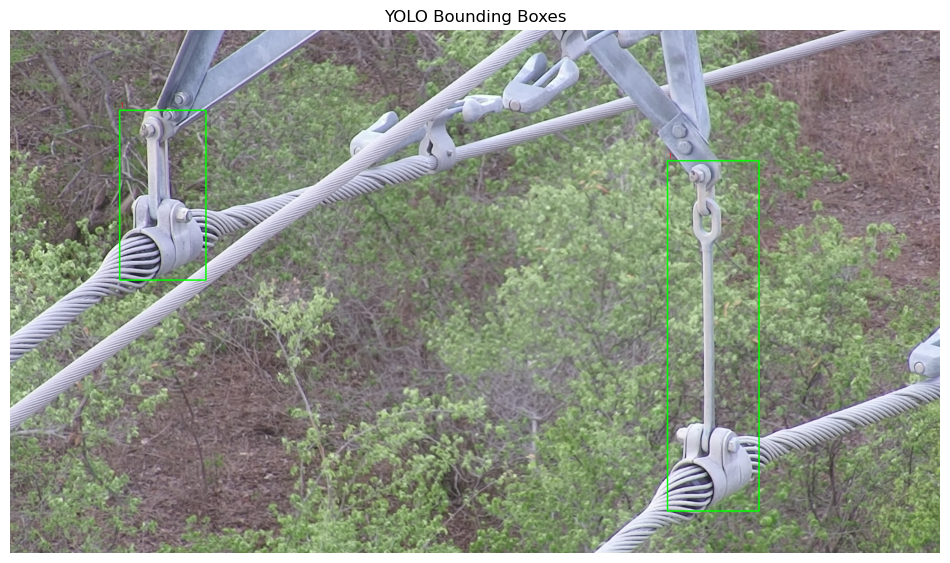

In [6]:
import cv2
import matplotlib.pyplot as plt
import os

# === CONFIG ===
image_path = 'data/InsPLAD-det/val/images/309-1_DJI_0053.jpg'  # path to a sample image
label_path = 'data/InsPLAD-det/val/labels/309-1_DJI_0053.txt'  # same name as image but .txt
output_path = 'boxed_preview.jpg'  # or leave as None to just display

# Load image
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert for matplotlib
img_h, img_w = img.shape[:2]

# Load YOLO annotations
with open(label_path, 'r') as f:
    lines = f.readlines()

for line in lines:
    class_id, x_center, y_center, width, height = map(float, line.strip().split())

    # Convert normalized to absolute
    x_center *= img_w
    y_center *= img_h
    width *= img_w
    height *= img_h

    x1 = int(x_center - width / 2)
    y1 = int(y_center - height / 2)
    x2 = int(x_center + width / 2)
    y2 = int(y_center + height / 2)

    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(img, f"{int(class_id)}", (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

# Show with matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')
plt.title("YOLO Bounding Boxes")
plt.show()
# Optional: save result
# cv2.imwrite(output_path, img)